In [1]:
import sys
sys.path.insert(0, "/Users/sophusmechlenburg/PycharmProjects/python_for_the_financial_economist")

"""
Load relevant packages
"""
    
# numpy for vector and matrix calculations + simulation
import numpy as np

# pandas 
import pandas as pd

# scipy
from scipy import stats

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# pandas datareader for getting data from different APIs 
import pandas_datareader as pdr

# packages for working with dates and time
import datetime

# copula package
import copulas

"""
Load own functions/packages
"""

# set plotting style
from codelib.visualization.layout import DefaultStyle
DefaultStyle();

# My functions
import MyFunctions

# Get data

In [2]:
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

"""
Get the 30 industry portfolios
"""

reader = FamaFrenchReader("30_Industry_Portfolios_daily",
                          start=datetime.datetime(1950, 1, 1))

industry_port_daily = reader.read()

# print description
industry_port_daily['DESCR']
industry_port_daily = industry_port_daily[0] / 100

/var/folders/vf/zf6_b41x70xg9rvm080gvn5w0000gn/T/ipykernel_2101/2548808022.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_port_daily = reader.read()
/var/folders/vf/zf6_b41x70xg9rvm080gvn5w0000gn/T/ipykernel_2101/2548808022.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_port_daily = reader.read()


In [3]:
# Last 10 years
log_returns = np.log1p(industry_port_daily)
log_returns = log_returns.resample('W-FRI').sum()  # Resample to weekly (ending on Friday)
obs = len(log_returns)
log_returns = log_returns.loc["2015-01-07":"2024-12-31",:] # Include all full weeks from 2015-2024
log_returns_pd = log_returns
log_returns = log_returns.values
log_returns.shape

(521, 30)

# Detect outliers using MVE

<Figure size 1200x1000 with 0 Axes>

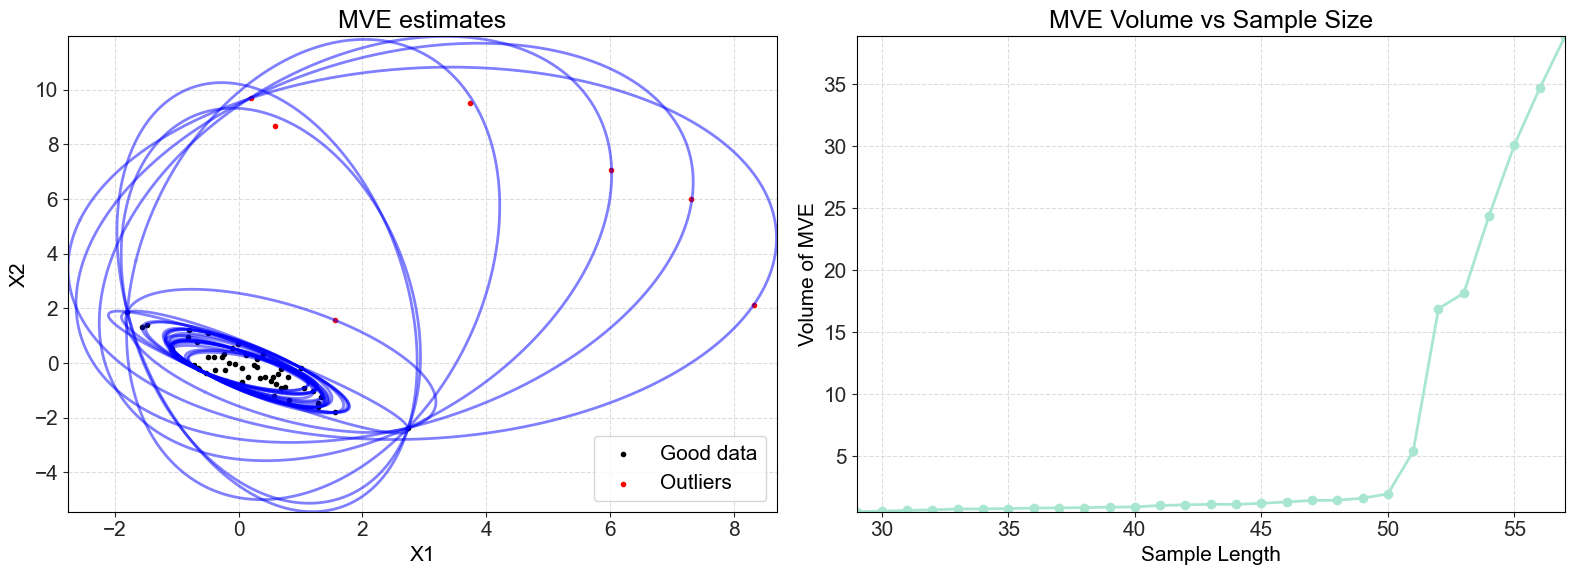

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def compute_mve(data):
    """
    Computes the minimum volume ellipsoid for a given time series.
    The location and scatter parameters that define the ellipsoid are
    multivariate high-breakdown estimators of location and scatter.
    
    Parameters:
    data (numpy.ndarray): Input data matrix, where each row is an observation
    
    Returns:
    tuple: (MVE_Location, MVE_Dispersion) - location vector and dispersion matrix
    """
    num_observations = data.shape[0]
    ones = np.ones(num_observations)
    m = np.mean(data, axis=0)
    S = np.cov(data, rowvar=False)
    
    det_S_new = 0
    w = np.ones(num_observations) / num_observations
    keep_loop = True
    
    while keep_loop:
        mahalanobis = np.zeros(num_observations)
        
        for t in range(num_observations):
            x_t = data[t, :]
            mahalanobis[t] = (x_t - m).T @ np.linalg.inv(S) @ (x_t - m)
        
        update = np.where(mahalanobis > 1)[0]
        w[update] = w[update] * mahalanobis[update]
        
        m = (data.T @ w) / np.sum(w)
        
        # Compute centered data matrix
        centered_data = data - np.outer(ones, m)
        
        # Compute weighted covariance matrix
        S = (centered_data.T @ np.diag(w) @ centered_data)
        
        det_S_old = det_S_new
        det_S_new = np.linalg.det(S)
        
        # Check convergence criterion
        keep_loop = (det_S_old / det_S_new < 0.99999) if det_S_old != 0 else True
    
    MVE_Location = m
    MVE_Dispersion = S
    
    return MVE_Location, MVE_Dispersion

def reject_outlier(sample, index=None):
    """
    Finds the "worst" outlier in a time series.
    
    Parameters:
    sample (numpy.ndarray): Input data matrix, where each row is an observation
    index (any): Not used in the function but kept for compatibility with original
    
    Returns:
    int: Index of the rejected (worst) outlier
    """
    # Get number of observations
    T = sample.shape[0]
    
    # Compute mean vector
    m = np.mean(sample, axis=0)
    
    # Center the data
    U = sample - np.outer(np.ones(T), m)
    
    # Compute leverage values (diagonal elements of the hat matrix)
    Lambda = np.diag(U @ np.linalg.inv(U.T @ U) @ U.T)
    
    # Find the index of the maximum leverage value
    rejected = np.argmax(Lambda)
    
    return rejected

def plot_ellipse(ax, mean, cov, scale=1.0, color='b', alpha=1.0):
    """
    Plots a 2D ellipse based on the specified mean and covariance matrix,
    following the MATLAB implementation approach.
    
    Parameters:
    ax (matplotlib.axes.Axes): The axis to plot on
    mean (numpy.ndarray): The mean vector of the distribution (location)
    cov (numpy.ndarray): The covariance matrix of the distribution (square dispersion)
    scale (float): Scaling factor for the ellipse
    color (str): Color of the ellipse
    alpha (float): Transparency of the ellipse
    """
    # Calculate eigenvalues and eigenvectors
    eigenvals, eigenvecs = np.linalg.eigh(cov)
    
    # Create angles for parametric representation
    angles = np.linspace(0, 2*np.pi, 1000)
    
    # Initialize centered ellipse
    centered_ellipse = np.zeros((2, len(angles)))
    
    # Create unit circle points
    for i, angle in enumerate(angles):
        y = np.array([np.cos(angle), np.sin(angle)])
        # Transform unit circle to ellipse
        centered_ellipse[:, i] = eigenvecs @ np.diag(np.sqrt(eigenvals)) @ y
    
    # Scale and translate the ellipse
    R = np.outer(mean, np.ones(len(angles))) + scale * centered_ellipse
    
    # Plot the ellipse
    ax.plot(R[0, :], R[1, :], color=color, alpha=alpha)
    
    return R


# Main script
np.random.seed(42)  # For reproducibility

# Generate observations
Mu = np.array([0, 0])  # Mean vector
r = -0.90  # Correlation coefficient
sig = np.array([1, 1])  # Standard deviations
T = 50  # Number of good observations
Outliers = 10 * np.random.rand(7, 2)  # 7 outlier points

# Construct covariance matrix
Sigma = np.diag(sig) @ np.array([[1, r], [r, 1]]) @ np.diag(sig)

# Generate "good" observations
Sample = multivariate_normal.rvs(mean=Mu, cov=Sigma, size=T)

# Add "bad" observations
CorruptSample = np.vstack((Sample, Outliers))

# Compute high-breakdown estimates
T = CorruptSample.shape[0]
Index = np.arange(T)
Sample_Length = []
Vol_MVE = []
Store = []

for j in range(int(np.ceil(T/2))):
    # Compute MVE
    MVE_Location, MVE_Dispersion = compute_mve(CorruptSample)
    
    # Store results
    Store.append({
        'MVE_Location': MVE_Location,
        'MVE_Dispersion': MVE_Dispersion,
        'Index': Index.copy()
    })
    
    Sample_Length.append(CorruptSample.shape[0])
    Vol_MVE.append(np.sqrt(np.linalg.det(MVE_Dispersion)))
    
    # Erase one outlier
    Rejected = reject_outlier(CorruptSample)
    CorruptSample = np.delete(CorruptSample, Rejected, axis=0)
    Index = np.delete(Index, Rejected)

# Plot results
plt.figure(figsize=(12, 10))

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Data and ellipsoids
ax1.scatter(Sample[:, 0], Sample[:, 1], color='k', marker='.', label='Good data')
ax1.scatter(Outliers[:, 0], Outliers[:, 1], color='r', marker='.', label='Outliers')

for j in range(len(Store)):
    plot_ellipse(ax1, Store[j]['MVE_Location'], Store[j]['MVE_Dispersion'], color='b', alpha=0.5)

ax1.set(title='MVE estimates', xlabel="X1", ylabel="X2")
ax1.legend()
ax1.grid(True)

# Plot 2: Volume of ellipsoid as function of sample length
ax2.plot(Sample_Length, Vol_MVE, marker='o')
ax2.set_xlabel('Sample Length')
ax2.set_ylabel('Volume of MVE')
ax2.set_title('MVE Volume vs Sample Size')
ax2.grid(True)

plt.tight_layout()
plt.show()

Iteration 1: Removed observation 271, new volume: 16553815640090411206992292307009536.000000
Iteration 2: Removed observation 272, new volume: 13195136534326801002987295420186624.000000
Iteration 3: Removed observation 270, new volume: 10099037982284302719872517892210688.000000
Iteration 4: Removed observation 274, new volume: 6700692441736828450678056933130240.000000
Iteration 5: Removed observation 273, new volume: 5046202418187067352666259201196032.000000
Iteration 6: Removed observation 287, new volume: 3608627568637499408869437604888576.000000
Iteration 7: Removed observation 382, new volume: 3289523539870791262001676649758720.000000
Iteration 8: Removed observation 96, new volume: 2865110984990577396540775537311744.000000
Iteration 9: Removed observation 373, new volume: 2331546525918809516618221185138688.000000
Iteration 10: Removed observation 275, new volume: 2047786606402031894463626828840960.000000
Iteration 11: Removed observation 268, new volume: 17368605272010922749667278

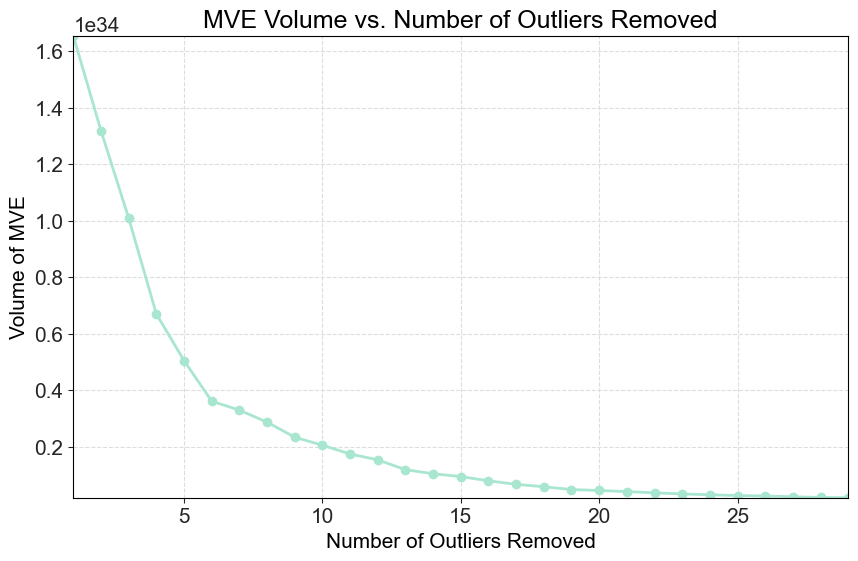

Identified outliers (original indices): [271, 272, 270, 274, 273, 287, 382, 96, 373, 275, 268, 388, 394, 381, 384, 380, 56, 277, 198, 409, 407, 171, 305, 269, 280, 282, 237, 511]


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

log_returns *= 100 #convert to percentages to not work with extremely small volume numbers

# Assuming log_returns is your dataset, either as numpy array or pandas DataFrame
# If it's a pandas DataFrame, convert to numpy array
if isinstance(log_returns, pd.DataFrame):
    returns_data = log_returns.values
else:
    returns_data = log_returns

# Store original indices to track which observations are outliers
original_indices = np.arange(returns_data.shape[0])
current_data = returns_data.copy()
current_indices = original_indices.copy()

# Arrays to store results
removed_indices = []
volumes = [np.inf]  # Start with infinity to see the initial drop
sample_sizes = [returns_data.shape[0]]

# Set a stopping criterion - you can adjust these
max_iterations = min(50, returns_data.shape[0] // 2)  # Don't remove more than half the data
volume_change_threshold = 0.05  # Stop if volume doesn't decrease significantly

for i in range(max_iterations):
    # Compute MVE for current data
    mve_location, mve_dispersion = compute_mve(current_data)
    
    # Store current volume
    current_volume = np.sqrt(np.linalg.det(mve_dispersion))
    volumes.append(current_volume)
    
    # Check stopping criterion based on volume change
    if i > 0 and (volumes[-2] - volumes[-1]) / volumes[-2] < volume_change_threshold:
        print(f"Stopping after {i} iterations: volume not decreasing significantly")
        break
    
    # Find worst outlier
    rejected_idx = reject_outlier(current_data)
    removed_idx = current_indices[rejected_idx]
    removed_indices.append(removed_idx)
    
    # Remove the outlier
    current_data = np.delete(current_data, rejected_idx, axis=0)
    current_indices = np.delete(current_indices, rejected_idx)
    
    # Store current sample size
    sample_sizes.append(current_data.shape[0])
    
    print(f"Iteration {i+1}: Removed observation {removed_idx}, new volume: {current_volume:.6f}")

# Plot the volume curve to help identify the "elbow"
plt.figure(figsize=(10, 6))
plt.plot(range(len(volumes)), volumes, marker='o')
plt.title('MVE Volume vs. Number of Outliers Removed')
plt.xlabel('Number of Outliers Removed')
plt.ylabel('Volume of MVE')
plt.grid(True)
plt.show()

# The identified outliers
print("Identified outliers (original indices):", removed_indices)

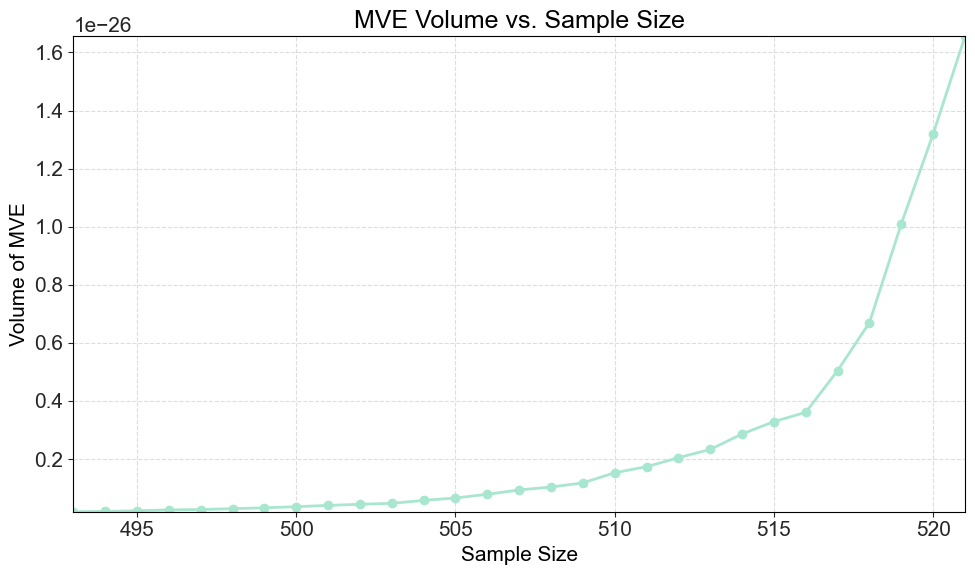

In [7]:
# Plot Volume MVE against Sample Length
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, volumes[1:], marker='o', linestyle='-')  # volumes[1:] to skip the initial infinity value
plt.title('MVE Volume vs. Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Volume of MVE')
plt.grid(True)

# Add arrows to show the direction of point removal
#for i in range(len(sample_sizes)-1):
#    plt.annotate('', 
#                 xy=(sample_sizes[i+1], volumes[i+2] if i+2 < len(volumes) else volumes[i+1]), 
#                 xytext=(sample_sizes[i], volumes[i+1]),
#                 arrowprops=dict(arrowstyle='->', color='red', lw=1))

plt.tight_layout()
plt.show()

In [8]:
log_returns_pd.iloc[removed_indices]

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-20,-0.128991,-0.174517,-0.209976,-0.102142,-0.186609,-0.124873,-0.163222,-0.122130,-0.155896,-0.433303,...,-0.153884,-0.145784,-0.152654,-0.129749,-0.154943,-0.188770,-0.068745,-0.212454,-0.222273,-0.149863
2020-03-27,0.071684,0.142434,0.111367,0.107845,0.057319,0.069511,0.151372,0.074786,0.083794,0.265029,...,0.070914,0.084393,0.098688,0.077850,0.145306,0.117216,0.054731,0.122547,0.127351,0.084754
2020-03-13,-0.098861,-0.112081,-0.077687,-0.153905,-0.096757,-0.073726,-0.169140,-0.087184,-0.126647,-0.245243,...,-0.074867,-0.067905,-0.075392,-0.104288,-0.138295,-0.130827,-0.074593,-0.128335,-0.100027,-0.094039
2020-04-10,0.077076,0.097688,0.050109,0.109714,0.140658,0.042951,0.149978,0.081770,0.192858,0.300622,...,0.100675,0.108758,0.098562,0.106217,0.123151,0.146506,0.086017,0.184358,0.175627,0.091458
2020-04-03,0.033034,0.020179,0.045132,-0.057092,-0.079285,0.016022,-0.084140,0.030340,-0.058771,-0.198783,...,-0.021268,-0.020057,-0.020379,-0.016214,-0.075832,-0.062402,-0.008197,-0.076855,-0.073760,-0.022846
2020-07-10,0.008388,0.009911,0.029705,0.085817,-0.007504,0.018200,-0.004612,-0.001055,0.004832,-0.264226,...,0.021929,0.031399,0.032480,-0.015904,0.004909,-0.022205,0.062674,0.010353,0.001003,0.002855
2022-05-06,0.000934,-0.007572,0.000581,-0.047271,-0.098374,-0.025966,-0.086684,-0.012953,0.024824,0.044990,...,0.021650,-0.021869,0.002940,0.002208,-0.023451,0.007966,-0.039184,-0.022998,0.003042,-0.001209
2016-11-11,-0.023952,-0.026979,-0.047983,0.002281,0.084777,-0.001921,0.044613,0.069467,0.036530,0.057471,...,0.035738,0.016940,0.036247,0.032610,0.073370,0.078397,0.032584,0.039636,0.101270,0.079983
2022-03-04,-0.002813,-0.002772,-0.018687,-0.078481,-0.011936,-0.026661,-0.062883,0.003277,-0.030306,-0.034158,...,-0.018737,-0.033755,-0.017138,-0.028166,-0.016303,0.001943,-0.010205,-0.055061,-0.054182,0.019792


In [9]:
removed_indices

[271,
 272,
 270,
 274,
 273,
 287,
 382,
 96,
 373,
 275,
 268,
 388,
 394,
 381,
 384,
 380,
 56,
 277,
 198,
 409,
 407,
 171,
 305,
 269,
 280,
 282,
 237,
 511]

# 20 years

In [10]:
# Last 20 years
calc = np.log1p(industry_port_daily)
calc = calc.resample('W-FRI').sum()  # Resample to weekly (ending on Friday)
obs = len(calc)
log_returns_20_yrs = calc.loc["2005-01-01":,:]
log_returns_20_yrs_percent = log_returns_20_yrs.values * 100 # used in MVE
log_returns_20_yrs.shape

(1044, 30)

Iteration 1: Removed observation 793, new volume: 1251208183357983605951758732110069760.000000
Iteration 2: Removed observation 196, new volume: 1066194609423218485869426118846578688.000000
Iteration 3: Removed observation 794, new volume: 763045342352358857789850433164935168.000000
Iteration 4: Removed observation 792, new volume: 644115084981935629465039459934273536.000000
Iteration 5: Removed observation 796, new volume: 509826047830125904973724921060392960.000000
Iteration 6: Removed observation 795, new volume: 409616736018922546872699682826485760.000000
Iteration 7: Removed observation 203, new volume: 291702659769312641877119660852248576.000000
Iteration 8: Removed observation 202, new volume: 256918840196929105491903332162207744.000000
Iteration 9: Removed observation 218, new volume: 224168329932229320283871432396505088.000000
Iteration 10: Removed observation 197, new volume: 176043945822088063224437489591648256.000000
Iteration 11: Removed observation 198, new volume: 139156

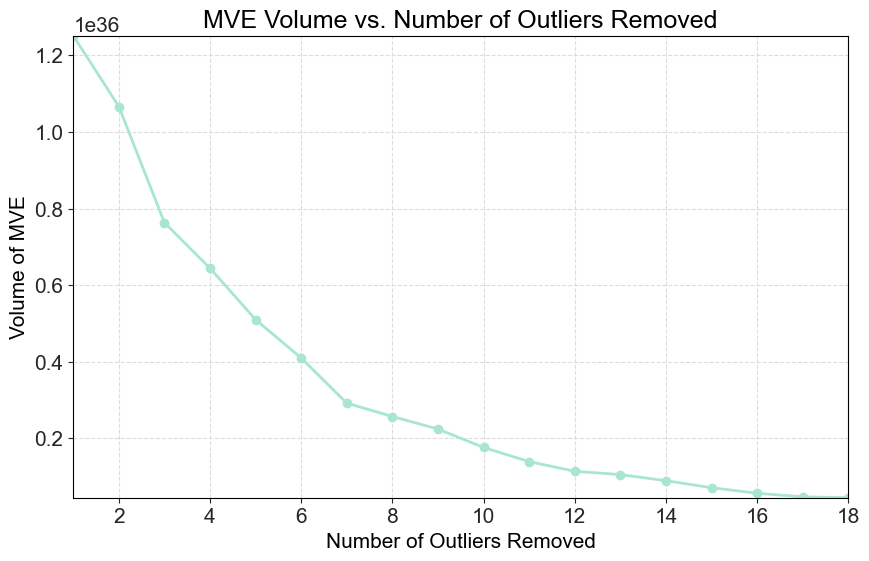

Identified outliers (original indices): [793, 196, 794, 792, 796, 795, 203, 202, 218, 197, 198, 809, 226, 204, 213, 205, 224]


In [11]:
# Assuming log_returns is your dataset, either as numpy array or pandas DataFrame
# If it's a pandas DataFrame, convert to numpy array
if isinstance(log_returns_20_yrs_percent, pd.DataFrame):
    returns_data = log_returns_20_yrs_percent.values
else:
    returns_data = log_returns_20_yrs_percent

# Store original indices to track which observations are outliers
original_indices = np.arange(returns_data.shape[0])
current_data = returns_data.copy()
current_indices = original_indices.copy()

# Arrays to store results
removed_indices = []
volumes = [np.inf]  # Start with infinity to see the initial drop
sample_sizes = [returns_data.shape[0]]

# Set a stopping criterion - you can adjust these
max_iterations = min(50, returns_data.shape[0] // 2)  # Don't remove more than half the data
volume_change_threshold = 0.05  # Stop if volume doesn't decrease by 5%

for i in range(max_iterations):
    # Compute MVE for current data
    mve_location, mve_dispersion = compute_mve(current_data)
    
    # Store current volume
    current_volume = np.sqrt(np.linalg.det(mve_dispersion))
    volumes.append(current_volume)
    
    # Check stopping criterion based on volume change
    if i > 0 and (volumes[-2] - volumes[-1]) / volumes[-2] < volume_change_threshold:
        print(f"Stopping after {i} iterations: volume not decreasing significantly")
        break
    
    # Find worst outlier
    rejected_idx = reject_outlier(current_data)
    removed_idx = current_indices[rejected_idx]
    removed_indices.append(removed_idx)
    
    # Remove the outlier
    current_data = np.delete(current_data, rejected_idx, axis=0)
    current_indices = np.delete(current_indices, rejected_idx)
    
    # Store current sample size
    sample_sizes.append(current_data.shape[0])
    
    print(f"Iteration {i+1}: Removed observation {removed_idx}, new volume: {current_volume:.6f}")

# Plot the volume curve to help identify the "elbow"
plt.figure(figsize=(10, 6))
plt.plot(range(len(volumes)), volumes, marker='o')
plt.title('MVE Volume vs. Number of Outliers Removed')
plt.xlabel('Number of Outliers Removed')
plt.ylabel('Volume of MVE')
plt.grid(True)
plt.show()

# The identified outliers
print("Identified outliers (original indices):", removed_indices)

In [12]:
panic_returns = log_returns_20_yrs.iloc[removed_indices]
panic_returns

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-20,-0.128991,-0.174517,-0.209976,-0.102142,-0.186609,-0.124873,-0.163222,-0.122130,-0.155896,-0.433303,...,-0.153884,-0.145784,-0.152654,-0.129749,-0.154943,-0.188770,-0.068745,-0.212454,-0.222273,-0.149863
2008-10-10,-0.159749,-0.190602,-0.187046,-0.220312,-0.216235,-0.175618,-0.146478,-0.192505,-0.170961,-0.168888,...,-0.234755,-0.173626,-0.149693,-0.168891,-0.121306,-0.186295,-0.163442,-0.142580,-0.241803,-0.118233
2020-03-27,0.071684,0.142434,0.111367,0.107845,0.057319,0.069511,0.151372,0.074786,0.083794,0.265029,...,0.070914,0.084393,0.098688,0.077850,0.145306,0.117216,0.054731,0.122547,0.127351,0.084754
2020-03-13,-0.098861,-0.112081,-0.077687,-0.153905,-0.096757,-0.073726,-0.169140,-0.087184,-0.126647,-0.245243,...,-0.074867,-0.067905,-0.075392,-0.104288,-0.138295,-0.130827,-0.074593,-0.128335,-0.100027,-0.094039
2020-04-10,0.077076,0.097688,0.050109,0.109714,0.140658,0.042951,0.149978,0.081770,0.192858,0.300622,...,0.100675,0.108758,0.098562,0.106217,0.123151,0.146506,0.086017,0.184358,0.175627,0.091458
2020-04-03,0.033034,0.020179,0.045132,-0.057092,-0.079285,0.016022,-0.084140,0.030340,-0.058771,-0.198783,...,-0.021268,-0.020057,-0.020379,-0.016214,-0.075832,-0.062402,-0.008197,-0.076855,-0.073760,-0.022846
2008-11-28,0.051714,0.053959,0.064772,0.209332,0.212554,0.040888,0.145405,0.053740,0.116939,0.200012,...,0.155078,0.088462,0.100790,0.102240,0.107675,0.103545,0.110196,0.117793,0.235286,0.158347
2008-11-21,-0.055037,0.002877,-0.018564,-0.196525,-0.163573,-0.019327,-0.067471,-0.087260,-0.157380,-0.235409,...,-0.102160,-0.062341,-0.068550,-0.053420,-0.107382,-0.104944,-0.062000,-0.056753,-0.219685,-0.118086
2009-03-13,0.060070,0.041535,0.079562,0.144452,0.110455,0.043426,0.132853,0.084908,0.129492,0.199366,...,0.084182,0.073626,0.106490,0.113578,0.090470,0.060660,0.084102,0.072081,0.230685,0.172194


2025-03-30 11:33:57.405 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=46.496144)
2025-03-30 11:33:57.406 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted laplace distribution with error=48.549143)
2025-03-30 11:33:57.406 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted logistic distribution with error=45.36572)
2025-03-30 11:33:57.409 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=53.675082)
2025-03-30 11:33:57.435 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted skewnorm distribution with error=40.33736)
2025-03-30 11:33:57.686 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted t distribution with error=46.496153)


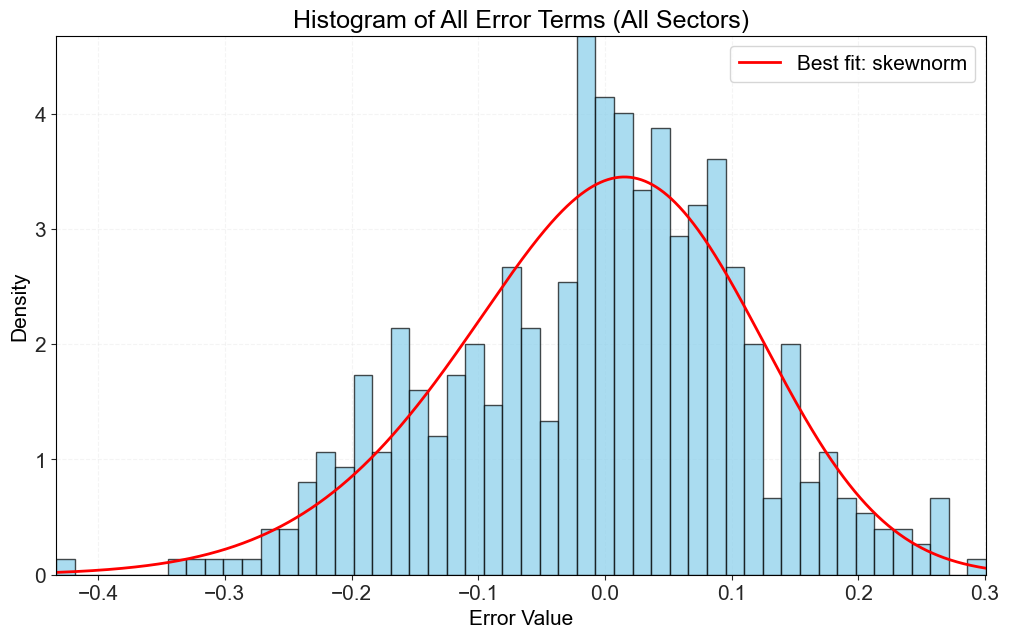

Best distribution for all pooled errors: skewnorm
Parameters: (-1.6140682096294054, 0.10295315463192482, 0.16156053310997884)


2025-03-30 11:33:58.145 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted laplace distribution with error=8786.628602)
2025-03-30 11:33:58.152 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted logistic distribution with error=8746.030225)
2025-03-30 11:33:58.152 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=8752.678851)
2025-03-30 11:33:58.199 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted skewnorm distribution with error=8303.172007)
2025-03-30 11:33:59.137 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=8785.300108)
2025-03-30 11:33:59.260 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted t distribution with error=8785.287622)
2025-03-30 11:33:59.415 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted laplace distribution with error=6494.193134)
2025-03-30 11:33:59.415 | INFO     | fitter.fitter:_fit_single_distrib

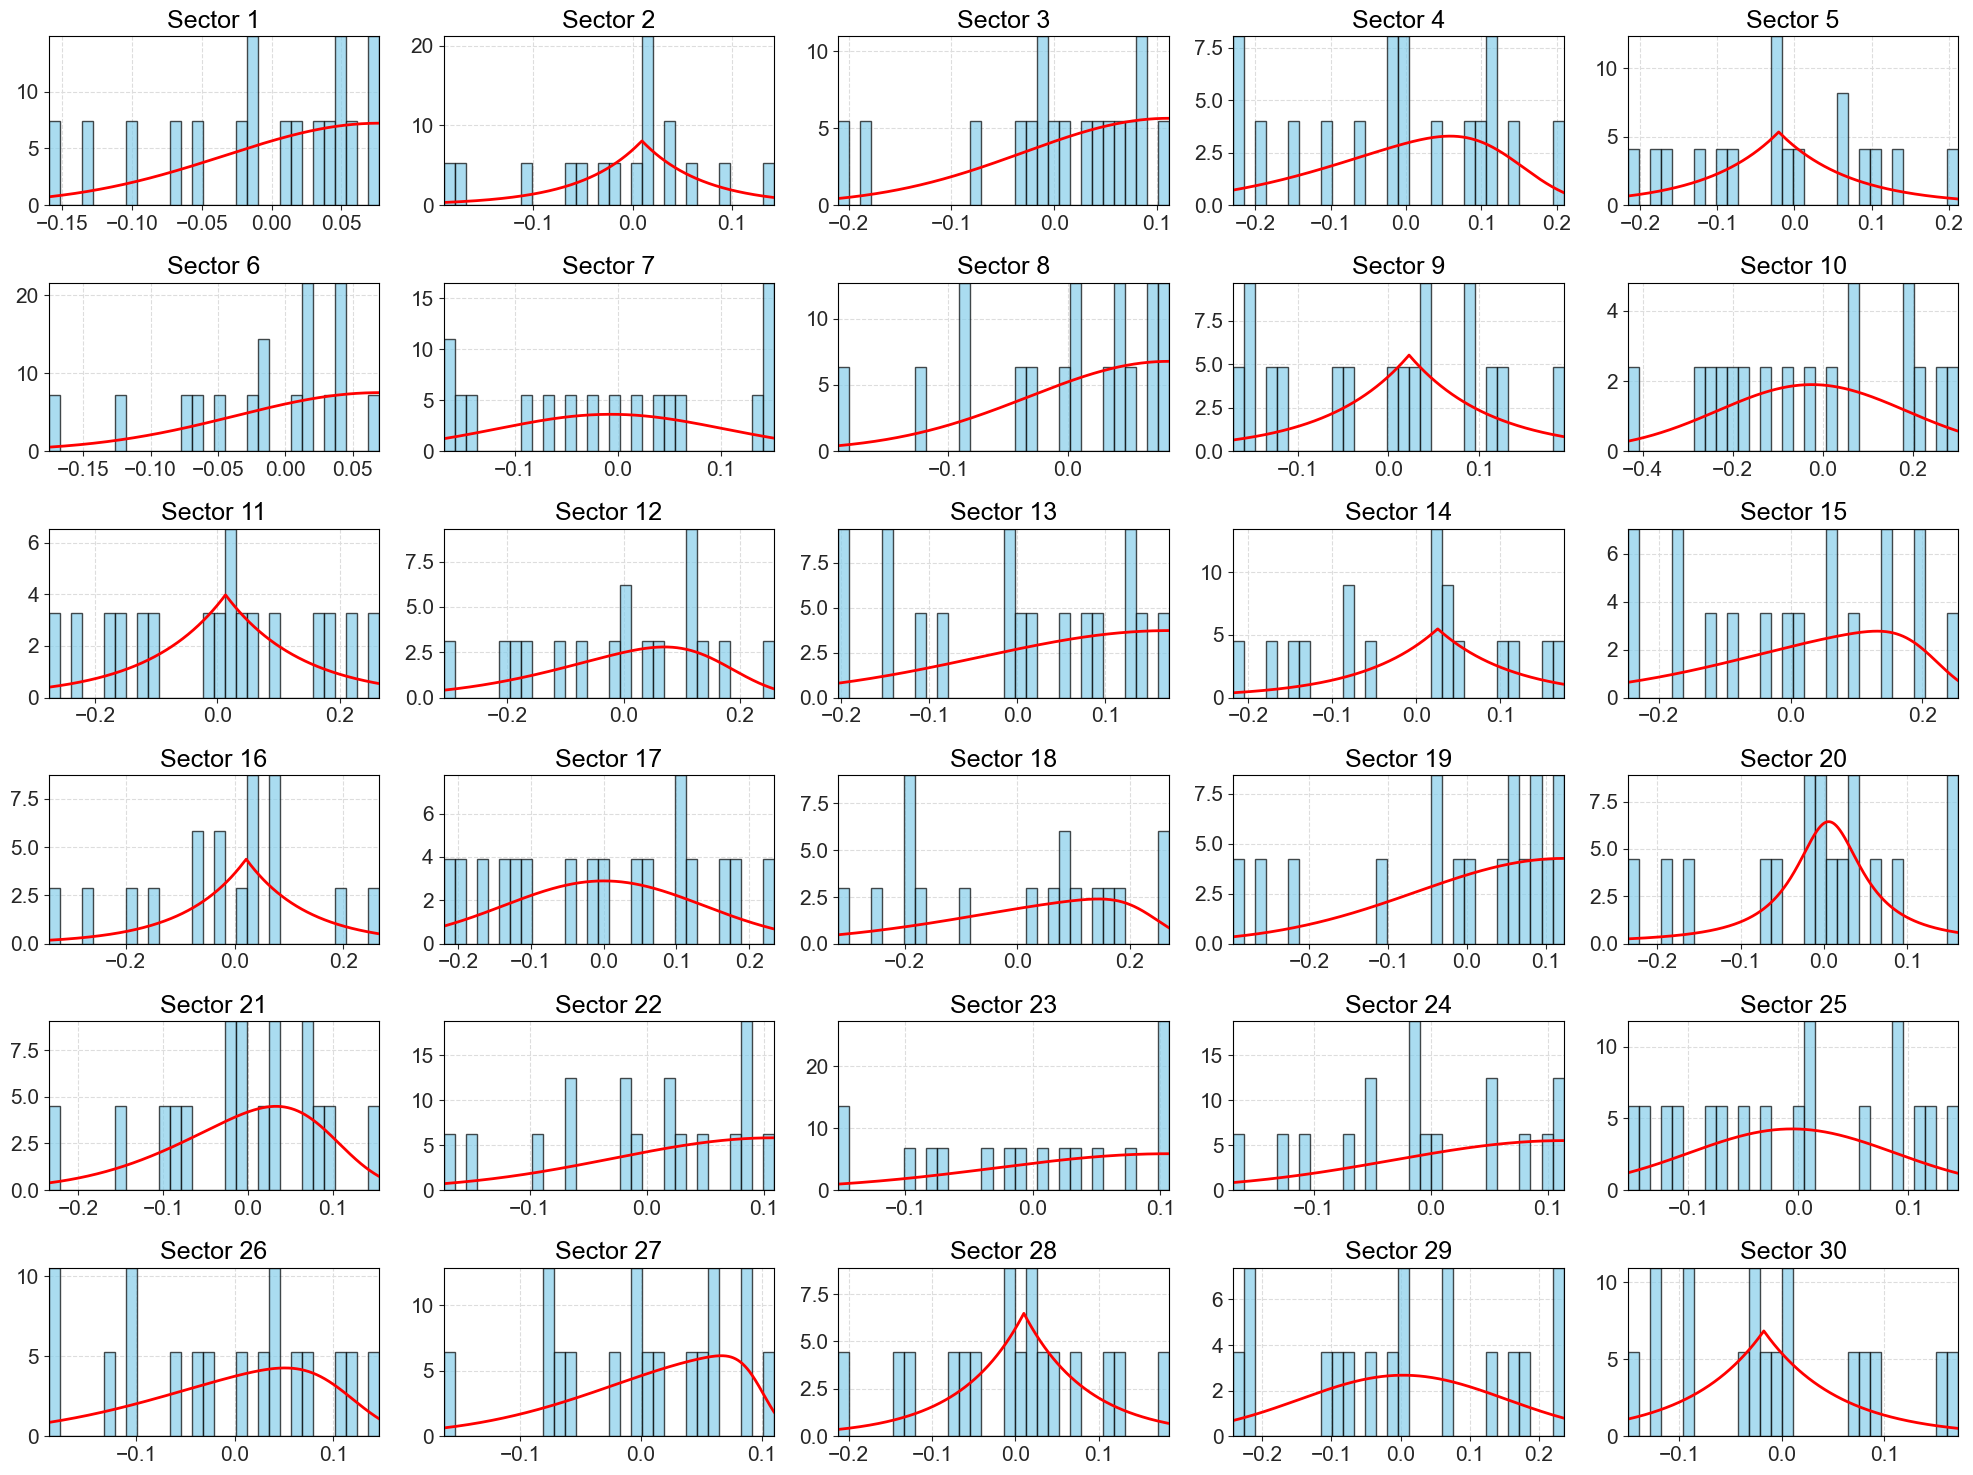

In [13]:
from fitter import Fitter


# 1. Option to analyze all errors together
all_errors = panic_returns.values.flatten()  # This combines all sectors into one array

# Create a histogram of all pooled errors
plt.figure(figsize=(12, 7))
plt.hist(all_errors, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Histogram of All Error Terms (All Sectors)')
plt.xlabel('Error Value')
plt.ylabel('Density')
plt.grid(alpha=0.3)

# Fit distributions to the pooled errors
distributions = ['norm', 't', 'laplace', 'cauchy', 'logistic', 'skewnorm']
f = Fitter(all_errors, distributions=distributions)
f.fit()
best_fit = f.get_best(method='sumsquare_error')

# Plot the best fitting distribution
x = np.linspace(min(all_errors), max(all_errors), 1000)
best_dist_name = list(best_fit.keys())[0]
best_dist_params = f.fitted_param[best_dist_name]
dist = getattr(stats, best_dist_name)

# Different distributions have different parameter ordering, handle accordingly
if best_dist_name == 'norm':
    y = dist.pdf(x, *best_dist_params)
elif best_dist_name == 't':
    y = dist.pdf(x, *best_dist_params)
else:
    # This is a simplification - may need adjusting based on the specific distribution
    y = dist.pdf(x, *best_dist_params)

plt.plot(x, y, 'r-', linewidth=2, label=f'Best fit: {best_dist_name}')
plt.legend()
plt.show()

print(f"Best distribution for all pooled errors: {best_dist_name}")
print(f"Parameters: {best_dist_params}")

#2 sector specific analysis

best_distributions = []
sector_summaries = {}

# Create a subplot grid for all sectors
fig, axes = plt.subplots(6, 5, figsize=(20, 15))  # 6×5 grid accommodates 30 sectors
axes = axes.flatten()

for i in range(30):
    sector_returns = panic_returns.values[:, i]
    
    # Plot histogram for this sector
    ax = axes[i]
    ax.hist(sector_returns, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f'Sector {i+1}')
    
    # Fit distributions
    f_sector = Fitter(sector_returns, distributions=distributions)
    f_sector.fit()
    best_sector_fit = f_sector.get_best(method='sumsquare_error')
    best_dist_name = list(best_sector_fit.keys())[0]
    best_distributions.append(best_dist_name)
    
    # Store summary
    sector_summaries[i+1] = {
        'distribution': best_dist_name,
        'parameters': f_sector.fitted_param[best_dist_name],
        'mean': np.mean(sector_returns),
        'std': np.std(sector_returns),
        'min': np.min(sector_returns),
        'max': np.max(sector_returns)
    }
    
    # Plot the best fit line
    x = np.linspace(min(sector_returns), max(sector_returns), 1000)
    dist = getattr(stats, best_dist_name)
    params = f_sector.fitted_param[best_dist_name]
    
    # Different distributions have different parameter ordering
    try:
        y = dist.pdf(x, *params)
        ax.plot(x, y, 'r-', linewidth=2)
    except:
        # Simplified fallback
        pass

plt.tight_layout()
plt.show()

In [15]:
best_distributions

['skewnorm',
 'laplace',
 'skewnorm',
 'skewnorm',
 'laplace',
 'skewnorm',
 'skewnorm',
 'skewnorm',
 'laplace',
 't',
 'laplace',
 'skewnorm',
 'skewnorm',
 'laplace',
 'skewnorm',
 'laplace',
 'skewnorm',
 'skewnorm',
 'skewnorm',
 'cauchy',
 'skewnorm',
 'skewnorm',
 'skewnorm',
 'skewnorm',
 'skewnorm',
 'skewnorm',
 'skewnorm',
 'laplace',
 'norm',
 'laplace']